# AI Agents in LangGraph – Lesson 3

In this lesson, the instructor shows how **agentic search tools** improve over traditional keyword search by
incorporating:

- **Query decomposition** (into sub-queries)
- **Multi-source retrieval** and **chunk-level ranking**
- **Top-k filtering** and **structured result formatting**

Below is an hands-on example using [Tavily](https://www.tavily.com/) search, which is then compared to a more traditional DuckDuckGo scraping pipeline.

### 🔁 Agentic Search Workflow
The diagram below shows how queries are processed in an agentic search system:

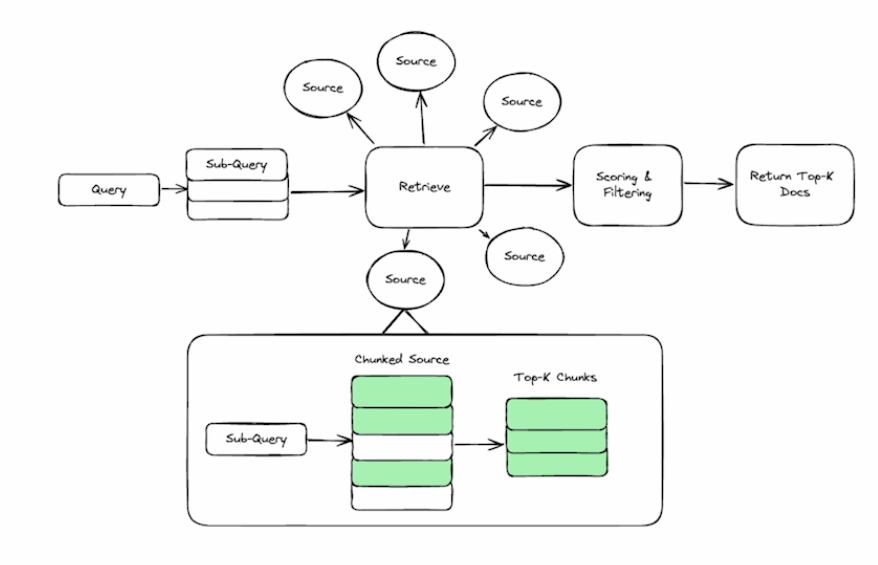

In [1]:
# Display diagram (from Tavily)
from IPython.display import Image
Image(filename='agentic_search_workflow.png')

## 1. Why Agentic Search?
While LLMs are powerful, they have **fixed knowledge** and can't handle questions like:
- "What happened last night in the game?"
- "What's the current weather in San Francisco?"

Also, LLMs often **hallucinate** facts. Agentic search adds retrieval + source grounding.


## 2. Setup and Load Tavily Key

In [2]:
# Install required libraries
# !pip install -q tavily-python duckduckgo-search beautifulsoup4 requests pygments

from dotenv import load_dotenv
import os
from tavily import TavilyClient

# Load key from .env (make sure it’s set)
load_dotenv()
client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

## 3. Agentic Search with Tavily

In [3]:
# Agentic search: auto-parses subqueries and returns structured result
result = client.search("What is in Nvidia's new Blackwell GPU?", include_answer=True)
print(result['answer'])

The new Blackwell GPU by Nvidia features up to 20 petaflops of performance and includes 208 billion transistors. It supports confidential computing and offers advanced multimedia acceleration.


## 4. Comparing Traditional vs Agentic Search

In [4]:
# Traditional scraping search
from duckduckgo_search import DDGS
import requests, re
from bs4 import BeautifulSoup

# Prompt used to search for weather information
city = "San Francisco"
query = f"""
    what is the current weather in {city}?
    Should I travel there today?
    "weather.com"
"""

# Search function
ddg = DDGS()

def search(query, max_results=6):
    try:
        results = ddg.text(query, max_results=max_results)
        return [i["href"] for i in results]

    except: # Fallback to weather.com if search fails
        return [
            "https://weather.com/weather/today/l/USCA0987:1:US",
            "https://weather.com/weather/hourbyhour/l/USCA0987:1:US"
        ]

links = search(query)
for i in links:
    print(i)

https://weather.com/en-NA/weather/today/l/San+Francisco+CA+United+States?canonicalCityId=e7784799733d2133bcb75674a102b347
https://weather.com/weather/today/l/San+Francisco+CA+USCA0987:1:US
https://weather.com/weather/tenday/l/San Francisco CA USCA0987:1:US


In [5]:
def scrape_weather_info(url):
    if not url:
        return "No URL provided"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to fetch"
    return BeautifulSoup(response.text, 'html.parser')

url = links[0]
soup = scrape_weather_info(url)
print(f"Website: {url}\n\n")
print(str(soup.body)[:5000])

Website: https://weather.com/en-NA/weather/today/l/San+Francisco+CA+United+States?canonicalCityId=e7784799733d2133bcb75674a102b347


<body><div class="appWrapper DaybreakLargeScreen LargeScreen lightTheme twcTheme DaybreakLargeScreen--appWrapper--ZkDop gradients--clearNight--cs6t9 gradients--clearNight-top--SVtBt" id="appWrapper"><div class="region-meta"><div class="removeIfEmpty" id="WxuHtmlHead-meta-"></div><div class="removeIfEmpty" id="WxuNewsroom-meta-bc9f40d5-d941-4fd8-bae2-2d8d63a38bb3"></div></div><div class="region-topAds regionTopAds DaybreakLargeScreen--regionTopAds--sDajQ"><div class="removeIfEmpty" id="WxuAd-topAds-53dce052-5465-4609-a555-c3a20ab64ab0"><div class="adWrapper BaseAd--adWrapper--ANZ1O BaseAd--card--cqv7t BaseAd--hide--hCG8L"><div class="adLabel BaseAd--adLabel--JGSp6">Advertisement</div><div class="ad_module BaseAd--ad_module--ajh9S subs-undefined BaseAd--placeholder--ofteC" id="WX_Hidden"></div></div></div><div class="removeIfEmpty" id="WxuAd-topAds-fe926b10

In [6]:
weather_data = []
for tag in soup.find_all(['h1', 'h2', 'h3', 'p']):
    text = tag.get_text(" ", strip=True)
    weather_data.append(text)

weather_data = re.sub(r'\s+', ' ', '\n'.join(weather_data))
print(weather_data[:2000])

recents Account Privacy Special Forecasts San Francisco, CA, United States Weather Today in San Francisco, CA, United States 06:05 20:07 Morning Afternoon Evening Overnight Hourly Forecast Now 06:00 07:00 08:00 09:00 Daily Forecast Today Sat 10 Sun 11 Mon 12 Tue 13 Radar Air Quality Index Air quality is considered satisfactory, and air pollution poses little or no risk. Health & Activities Seasonal Allergies and Pollen Count Forecast Grass pollen is high in your area We recognise our responsibility to use data and technology for good. We may use or share your data with our data vendors. Take control of your data. The Weather Channel is the world's most accurate forecaster according to ForecastWatch, Global and Regional Weather Forecast Accuracy Overview , 2017-2022, commissioned by The Weather Company. Weather Channel © The Weather Company, LLC 2025


## 5. Agentic Search Version (Tavily API)

In [7]:
result = client.search(query, max_results=1)
print(result['results'][0]['content'])

{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1746792753, 'localtime': '2025-05-09 05:12'}, 'current': {'last_updated_epoch': 1746792000, 'last_updated': '2025-05-09 05:00', 'temp_c': 11.1, 'temp_f': 52.0, 'is_day': 0, 'condition': {'text': 'Fog', 'icon': '//cdn.weatherapi.com/weather/64x64/night/248.png', 'code': 1135}, 'wind_mph': 2.7, 'wind_kph': 4.3, 'wind_degree': 210, 'wind_dir': 'SSW', 'pressure_mb': 1019.0, 'pressure_in': 30.08, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 86, 'cloud': 0, 'feelslike_c': 11.2, 'feelslike_f': 52.2, 'windchill_c': 7.3, 'windchill_f': 45.1, 'heatindex_c': 8.2, 'heatindex_f': 46.7, 'dewpoint_c': 7.3, 'dewpoint_f': 45.1, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 0.0, 'gust_mph': 5.5, 'gust_kph': 8.9}}


In [8]:
# Pretty-print result JSON with syntax highlighting
import json
from pygments import highlight, lexers, formatters

data = result['results'][0]['content']
parsed_json = json.loads(data.replace("'", '"'))
formatted_json = json.dumps(parsed_json, indent=4)
print(highlight(formatted_json, lexers.JsonLexer(), formatters.TerminalFormatter()))

{
    "location": {
        "name": "San Francisco",
        "region": "California",
        "country": "United States of America",
        "lat": 37.775,
        "lon": -122.4183,
        "tz_id": "America/Los_Angeles",
        "localtime_epoch": 1746792753,
        "localtime": "2025-05-09 05:12"
    },
    "current": {
        "last_updated_epoch": 1746792000,
        "last_updated": "2025-05-09 05:00",
        "temp_c": 11.1,
        "temp_f": 52.0,
        "is_day": 0,
        "condition": {
            "text": "Fog",
            "icon": "//cdn.weatherapi.com/weather/64x64/night/248.png",
            "code": 1135
        },
        "wind_mph": 2.7,
        "wind_kph": 4.3,
        "wind_degree": 210,
        "wind_dir": "SSW",
        "pressure_mb": 1019.0,
        "pressure_in": 30.08,
        "precip_mm": 0.0,
        "precip_in": 0.0,
        "humidity": 86,
        "cloud": 0,
        "feelslike_c": 11.2,
        "feelslike_f": 52.2,
        "windchill_c": 7.3,
        "windch

### Traditional Search vs Agentic Search: User Experience

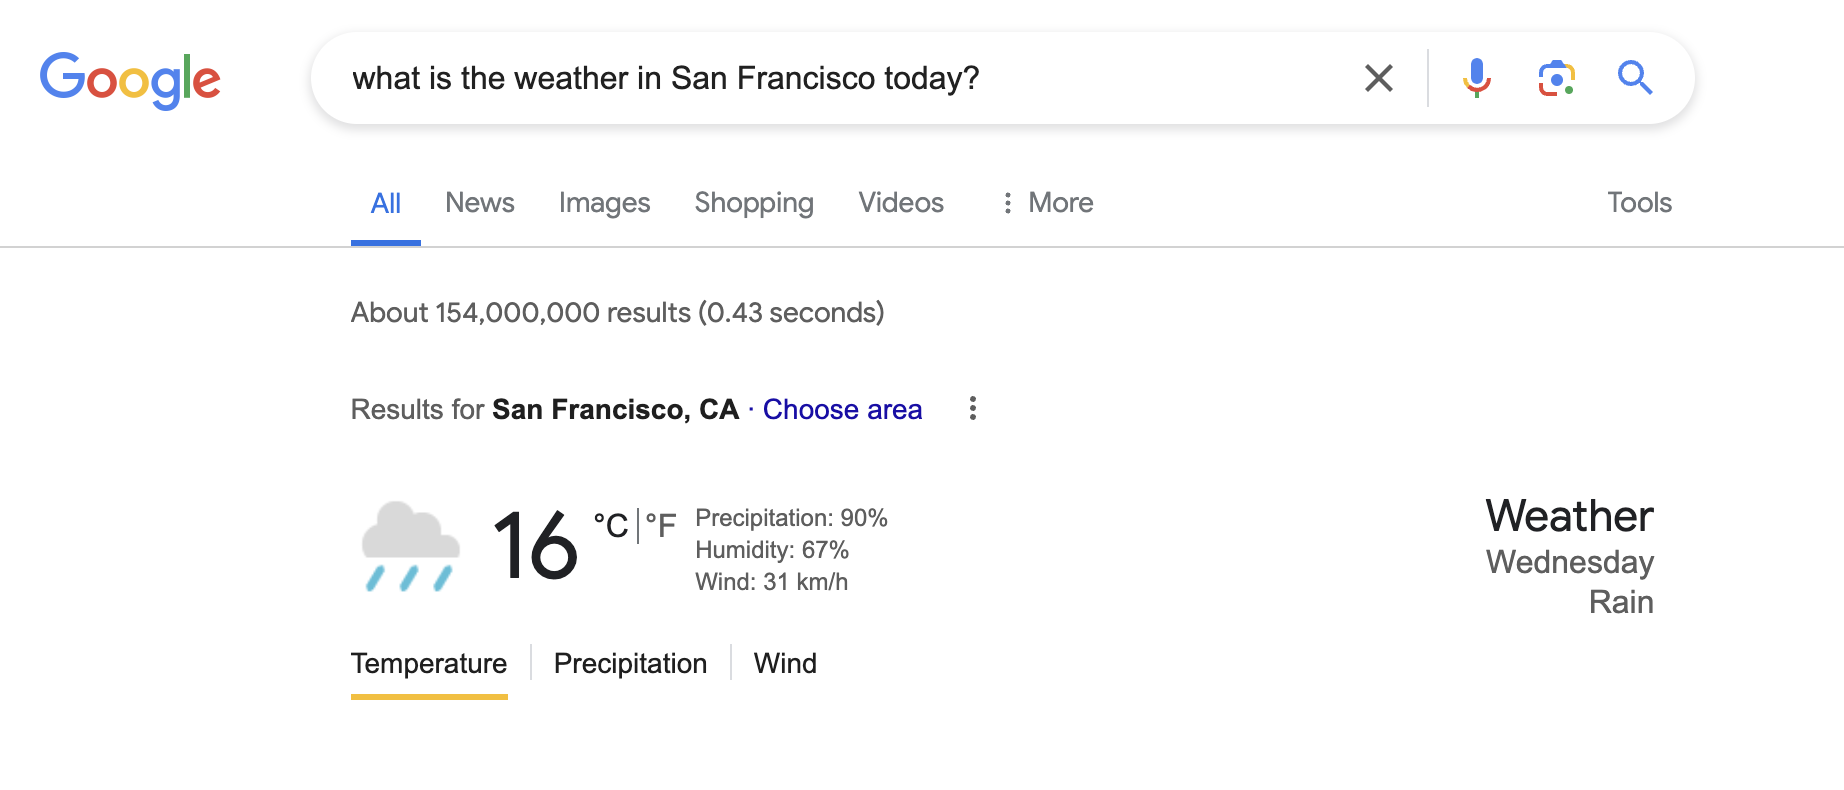

In [9]:
# Show screenshots of structured output as a user need with agentic search
from IPython.display import Image
Image(filename='google_sample.png') # Google style result

## Conclusion
- Traditional search shows **links** or raw snippets
- Agentic search returns **structured, contextual, source-grounded** answers

**Great for dynamic questions, multi-step reasoning, and hallucination-safe LLM applications**.